In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Get a list of column names and types
inspector = inspect(engine)
for table in inspector.get_table_names():
    columns = inspector.get_columns(table)
    print(f'Table {table}')
    for c in columns:
        print(c['name'], c["type"])
    print('---')

Table measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---
Table station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
---


# Exploratory Climate Analysis

In [11]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(func.max(Measurement.date)).scalar()
print(f"latest data point is {latest_date}")
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d")
last_12_months = dt.datetime(latest_date.year - 1, 
                             latest_date.month, 
                             latest_date.day)

# A query statement to retrieve the last 12 months of precipitation data
# query max of all stations for each day
stmt_prcp_12m = session.query(Measurement.date, func.max(Measurement.prcp))\
                .filter(Measurement.date > last_12_months)\
                .group_by(Measurement.date)\
                .order_by(Measurement.date)\
                .statement

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(stmt_prcp_12m, session.bind)
df.set_index('date', inplace=True)
df.columns=['precipitation']
df.tail(5)

latest data point is 2017-08-23


,precipitation
date,
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56
2017-08-22,0.50
2017-08-23,0.45


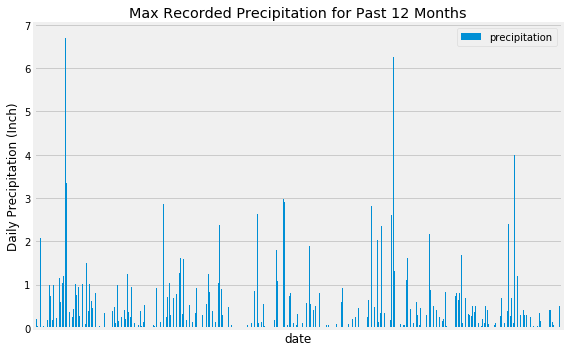

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='bar', figsize=(8,5))
plt.title('Max Recorded Precipitation for Past 12 Months')
plt.ylabel('Daily Precipitation (Inch)')
plt.xticks([])

# save and print chart
plt.tight_layout()
plt.savefig('Plots\MaxPrecip.png')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df['precipitation'].describe()

count    365.000000
mean       0.517288
std        0.829196
min        0.000000
25%        0.040000
50%        0.250000
75%        0.650000
max        6.700000
Name: precipitation, dtype: float64

### Station Analysis

In [14]:
# Design a query to show how many stations are available in this dataset?
n_stations = session.query(Measurement.station).distinct().count()
print(f"There are data from {n_stations} distinct weather stations in this dataset")

There are data from 9 distinct weather stations in this dataset


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
n_station_records = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()
n_station_records

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = n_station_records[0][0]
sel = [func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
results = session.query(*sel)\
            .filter(Measurement.station == station_id)\
            .all()

# print results
print(f"{station_id} is the most active station. Its")
print(f"minimum temperature is {results[0][0]},")
print(f"maximum temperature is {results[0][1]}, and")
print(f"average temperature is {results[0][2]:.1f}")


USC00519281 is the most active station. Its
minimum temperature is 54.0,
maximum temperature is 85.0, and
average temperature is 71.7


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
latest_date_s = session.query(func.max(Measurement.date))\
                .filter(Measurement.station == station_id)\
                .scalar()
print(f"latest data point for station {station_id} is {latest_date_s}")
latest_date_s = dt.datetime.strptime(latest_date_s, "%Y-%m-%d")
last_12_months_s = dt.datetime(latest_date_s.year - 1, 
                             latest_date_s.month, 
                             latest_date_s.day)

stmt_temp = session.query(Measurement.date, Measurement.tobs)\
                .filter(Measurement.station == station_id)\
                .filter(Measurement.date > last_12_months_s)\
                .order_by(Measurement.date)\
                .statement

df_temp = pd.read_sql_query(stmt_temp, session.bind)
df_temp.tail()

latest data point for station USC00519281 is 2017-08-18


,date,tobs
351,2017-08-14,77.0
352,2017-08-15,77.0
353,2017-08-16,76.0
354,2017-08-17,76.0
355,2017-08-18,79.0


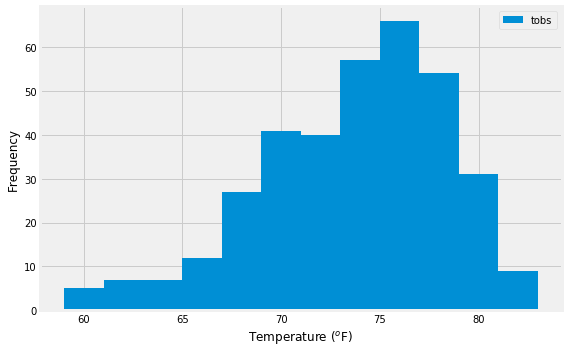

In [18]:
#plot the results as a histogram
df_temp.plot(kind='hist', bins=12, figsize=(8,5))
plt.xlabel('Temperature ($^o$F)')
plt.tight_layout()
plt.savefig("Plots\TemperatureHistogram.png")
plt.show()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_start = '2016-12-12'
my_trip_end = '2016-12-25'

[(TMin, TAvg, TMax)] = calc_temps(my_trip_start, my_trip_end)
print(TMin, TAvg, TMax)

60.0 70.8913043478261 78.0


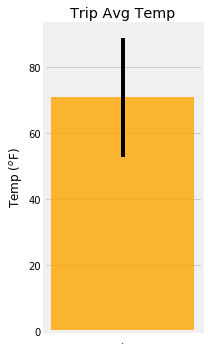

In [21]:
# Plot the results from your previous query as a bar chart.
fig = plt.figure(figsize=(3,5))
plt.bar('.', TAvg, yerr=TMax - TMin, 
        color='orange', alpha=0.8)
plt.title('Trip Avg Temp')
plt.ylabel('Temp ($^o$F)')
plt.grid(axis='x')

# save plot
plt.tight_layout()
plt.savefig("Plots\TemperatureBarChart.png")
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel =[Measurement.station, 
      Station.name, 
      Station.latitude, 
      Station.longitude,
      Station.elevation,
      func.sum(Measurement.prcp)
     ]
prcp_total = session.query(*sel)\
                .filter(Measurement.station==Station.station)\
                .filter(Measurement.date.between(my_trip_start, my_trip_end))\
                .group_by(Measurement.station)\
                .order_by(func.sum(Measurement.prcp).desc())\
                .statement

df_prcpTotal = pd.read_sql_query(prcp_total, session.bind)
df_prcpTotal.rename(columns={'sum_1': 'Total Precipitation'}, inplace=True)
df_prcpTotal

,station,name,latitude,longitude,elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.69
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.82
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.29
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.94
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.87
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.27
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.08


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
trip_start = '2016-12-12'
trip_end = '2016-12-25'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
d_start = dt.datetime.strptime(trip_start, "%Y-%m-%d")
d_end = dt.datetime.strptime(trip_end, "%Y-%m-%d")

day = d_start
day_string = []
md_string = []
while day <= d_end:
    day_string.append(day)
    md_string.append(day.strftime("%m-%d"))
    day += dt.timedelta(days=1)

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in md_string:
    normals.append(daily_normals(day)[0])
print(normals)

[(64.0, 70.88235294117646, 79.0), (65.0, 70.9423076923077, 80.0), (65.0, 71.18, 78.0), (62.0, 71.34, 79.0), (60.0, 69.62264150943396, 82.0), (63.0, 70.64, 77.0), (63.0, 71.28, 77.0), (67.0, 72.0, 78.0), (65.0, 72.91304347826087, 81.0), (67.0, 72.13953488372093, 78.0), (67.0, 71.1304347826087, 77.0), (61.0, 70.34693877551021, 78.0), (62.0, 70.0625, 78.0), (60.0, 71.75, 79.0)]


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normal = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df_normal['date'] = day_string
df_normal.set_index('date', inplace=True)
df_normal

,tmin,tavg,tmax
date,,,
2016-12-12,64.0,70.882353,79.0
2016-12-13,65.0,70.942308,80.0
2016-12-14,65.0,71.180000,78.0
2016-12-15,62.0,71.340000,79.0
2016-12-16,60.0,69.622642,82.0
2016-12-17,63.0,70.640000,77.0
2016-12-18,63.0,71.280000,77.0
2016-12-19,67.0,72.000000,78.0
2016-12-20,65.0,72.913043,81.0


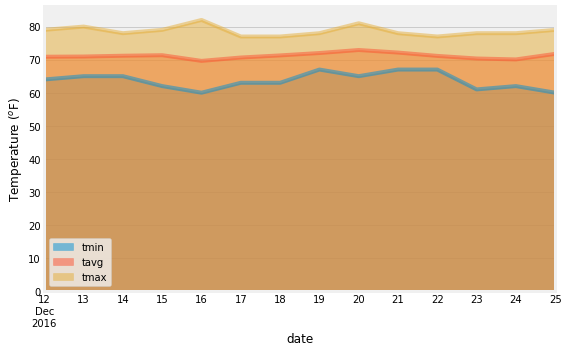

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
df_normal.plot(kind='area', stacked=False, figsize=(8,5))
plt.ylabel('Temperature ($^o$F)')
plt.tight_layout()
plt.savefig('Plots\TempNormal.png')
plt.show()